# Running Neural GAM - Linear regression

1. Install requirements
2. Load data
3. Train NeuralGAM
4. Visualize partial dependence plots

In [10]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import pandas as pd

Load dataset into Pandas Dataframes. If you want to preprocess or select some features, do it here. Our synthetic dataset is composed of train and test files, which we load separately.

In [11]:
from neuralGAM.dataset import generate_data

X_train, y_train, fs_train = generate_data(nrows=24500, err_type="homoscedastic", distribution = "uniform", family = "gaussian", seed=343142)

# center theoretical fs for plotting
fs_train = fs_train - fs_train.mean()

X_test, y_test, fs_test = generate_data(nrows=5000, err_type="homoscedastic", distribution = "uniform", family = "gaussian", seed=343142)
# center theoretical fs for plotting
fs_test = fs_test - fs_test.mean()


In [12]:
X_train.head()

,0,1,2
0,-1.606491,1.728811,-0.041242
1,-0.667678,1.269390,-1.848280
2,-0.008604,0.179919,-1.485737
3,0.431292,-2.136380,-0.556995
4,1.036414,-2.233529,2.294587


Create and Train NeuralGAM instance of Gaussian Family. 

In [13]:
from neuralGAM.model import NeuralGAM

output_path = "./results"
# Create results directory
if not os.path.exists(output_path):
    os.makedirs(output_path)

units = [128, 128, 128]
learning_rate = 0.00053

ngam = NeuralGAM(family="gaussian", num_units=units, learning_rate=learning_rate)

muhat, fs_train_estimated, eta = ngam.fit(X_train = X_train, 
                                y_train = y_train, 
                                max_iter_ls = 10, 
                                bf_threshold=10e-5,
                                ls_threshold=0.1,
                                max_iter_backfitting=10,
                                parallel=True)


766/766 [==============================] - 3s 4ms/step


Once we trained the model, we can visualize the learnt partial effects from the training set. In this case, we will use an auxiliary function that allows us to plot both the original (theretical) functions and the learnt partial effect from the training set

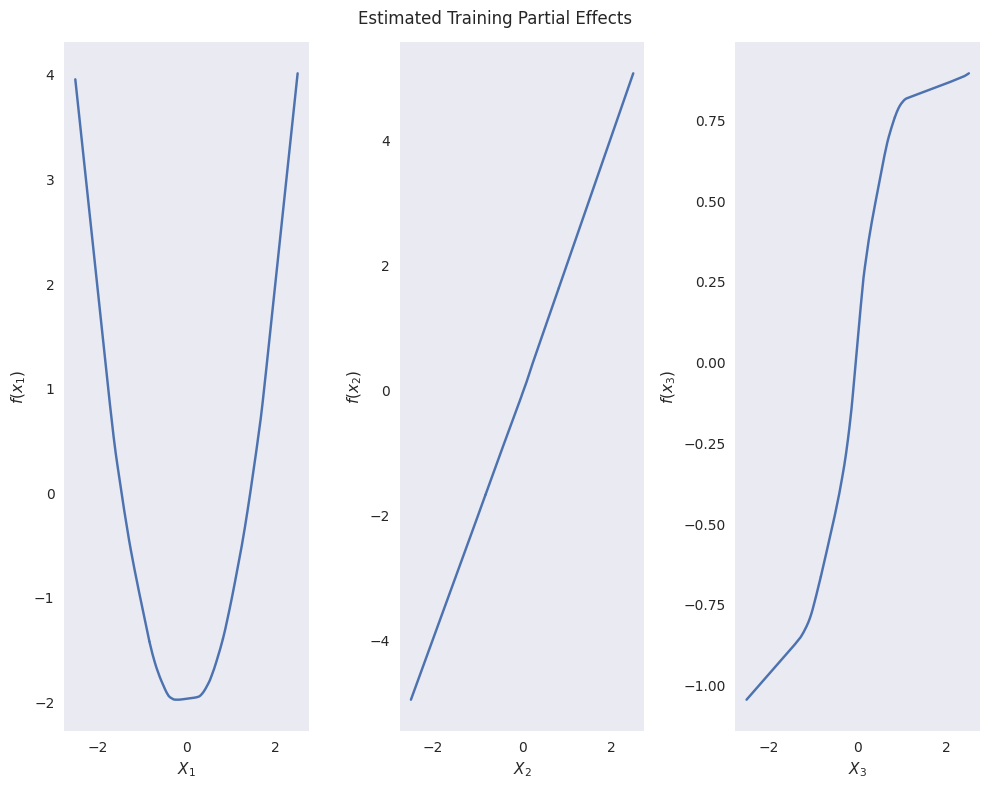

157/157 [==============================] - 0s 1ms/step


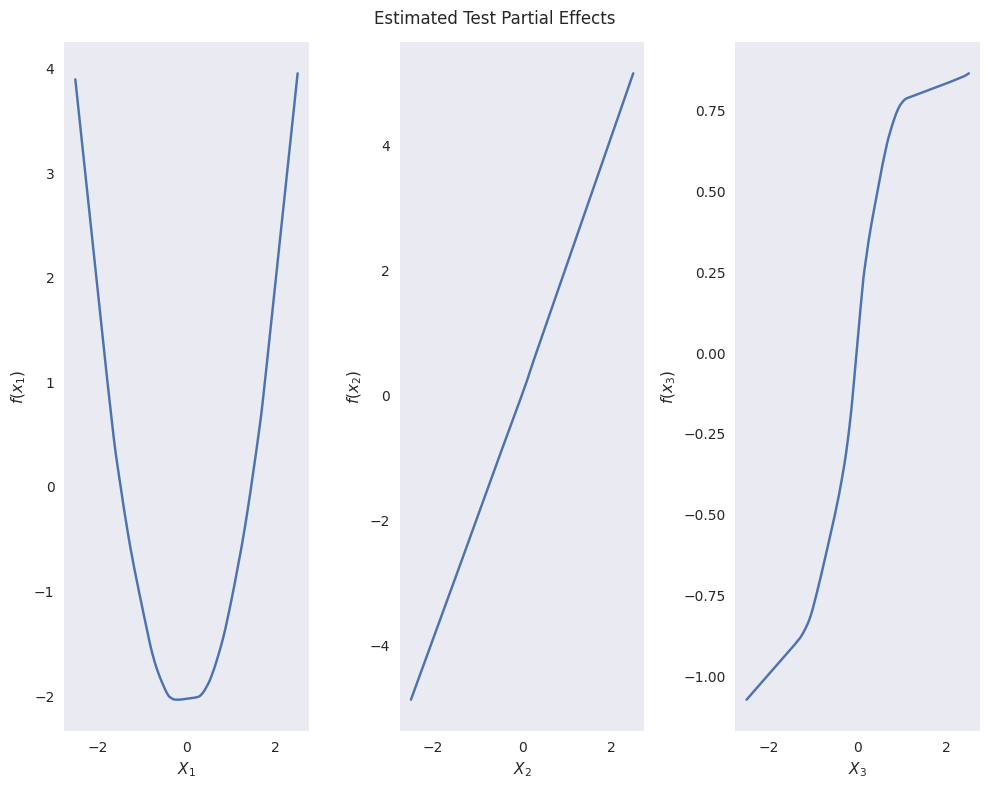

In [14]:
from neuralGAM.plot import plot_partial_dependencies
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plot_partial_dependencies(x=X_train, fs=fs_train_estimated, title="Estimated Training Partial Effects")

fs_test_est = ngam.predict(X_test, type = "terms")
plot_partial_dependencies(x=X_test, fs=fs_test_est, title="Estimated Test Partial Effects")

Since we observe a linear fit for $X_2$ we can force a linear fit for this covariate (using the column name in X_train) using the `linear_terms` parameter and specifying the column name in `X_train` to be fitted using a linear model:

766/766 [==============================] - 1s 2ms/step


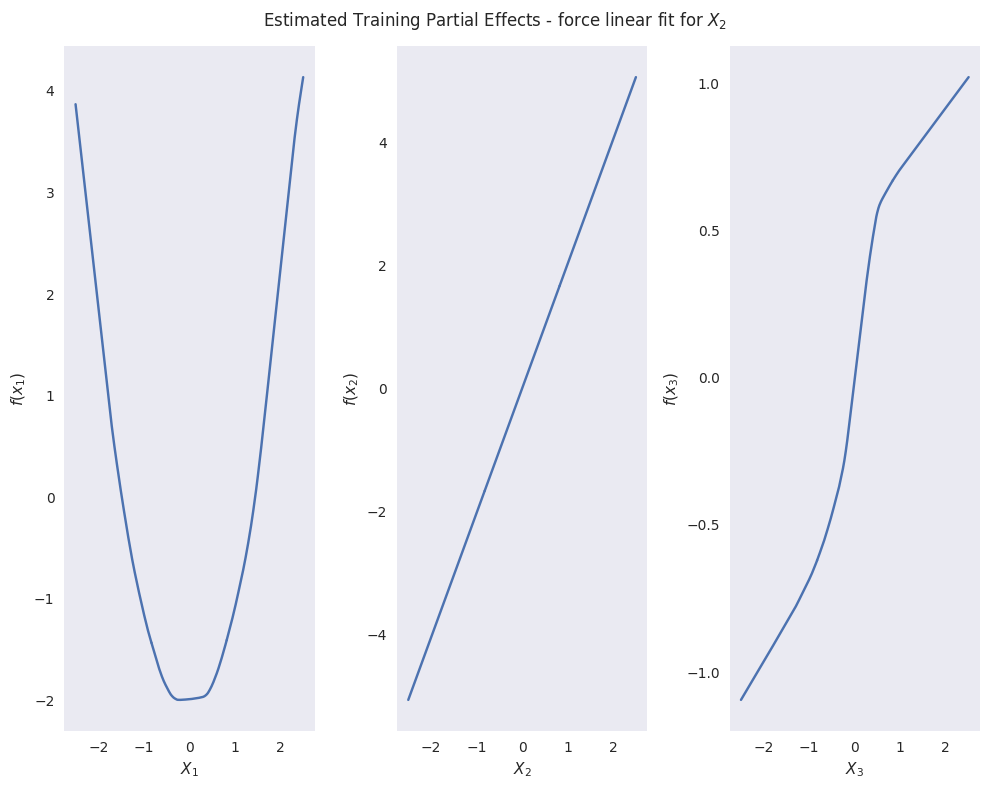

In [15]:
ngam = NeuralGAM(family="gaussian", num_units=units, learning_rate=learning_rate, linear_terms=[1])

muhat, fs_train_estimated, eta = ngam.fit(X_train = X_train, 
                                y_train = y_train, 
                                max_iter_ls = 10, 
                                bf_threshold=10e-5,
                                ls_threshold=0.1,
                                max_iter_backfitting=10,
                                parallel=True)

plot_partial_dependencies(x=X_train, fs=fs_train_estimated, title=f"Estimated Training Partial Effects - force linear fit for $X_2$")


We can now use the trained NeuralGAM model to make predictions on unseen data, and compute the MSE between the trained and predicted estimations: 

In [16]:
y_pred = ngam.predict(X_test, type = "response")
pred_err = mean_squared_error(y_test, y_pred)
print("MSE in the test set = {0}".format(str(pred_err)))

157/157 [==============================] - 0s 923us/step
MSE in the test set = 0.29890639453220963
